### [EXP_14] 한국어 데이터로 챗봇 만들기

##### 0. 라이브러리 로드

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.6.0


##### Step 1. 데이터 수집하기

In [2]:
path_to_zip = '/home/evergrin/python/notebook/data/transformer/'
path_to_zip = '/aiffel/aiffel/transformer_chatbot/data/'
path_to_dataset = os.path.join(path_to_zip, 'ChatbotData.csv')

print(path_to_dataset)

/aiffel/aiffel/transformer_chatbot/data/ChatbotData.csv


In [87]:
with open(path_to_dataset, 'r') as file:
    lines = file.readlines()

print(lines[:3])

['Q,A,label\n', '12시 땡!,하루가 또 가네요.,0\n', '1지망 학교 떨어졌어,위로해 드립니다.,0\n']


첫줄은 컬럼 이름으로, Q, A, label로 구분하고,  
데이터 값도 질문, 답, 라벨로 추정되는 (0-2)값으로 ','로 구분되어 있습니다.  
"xxxx" 안에 여러개의 ','가 있는 경우도 있습니다.  

In [88]:
lines = lines[1:]
print(lines[:3])

['12시 땡!,하루가 또 가네요.,0\n', '1지망 학교 떨어졌어,위로해 드립니다.,0\n', '3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0\n']


In [89]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = len(lines)
print(MAX_SAMPLES)

11823


##### Step 2. 데이터 전처리하기

In [90]:
from konlpy.tag import Mecab

mecab = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
words_set = list()


In [91]:
# 전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = sentence.replace('\n', '')   # 개행문자 제거.
    sentence = re.sub(pattern=r"(\".*\")",  # 따옴표 안에 ',' 를 제거함.
                    repl=lambda x: str(x.group()).replace(',',''), 
                    string=sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    sentence = re.sub(r'[" "]+', " ", sentence)

#     sentence = mecab.morphs(sentence) # 토큰화
#     sentence = [word for word in sentence if not word in stopwords] # 불용어 제거
#     words_set = words_set.extend(sentence)
#     sentence = " ".join(sentence)
    return sentence

In [92]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
# label은 사용하지 않음.

def load_conversations():
    inputs, outputs, labels = [], [], []
    with open(path_to_dataset, 'r') as file:
        lines = file.readlines()

    for line in lines[1:]:
        line2 = preprocess_sentence(line)
        parts = line2.split(',')
        
        # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
        inputs.append(parts[0])
        outputs.append(parts[1])
        labels.append(int(parts[2]))

        if len(inputs) >= MAX_SAMPLES:
          return inputs, outputs
    return inputs, outputs

In [93]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations()
print('전체 질문 샘플 수 :', len(questions))
print('전체 대답 샘플 수 :', len(answers))
# print('전체 단어 샘플 수 :', len(words_set))


전체 질문 샘플 수 : 11823
전체 대답 샘플 수 : 11823


In [92]:
# 전처리된 내용을 csv파일로 저장
path_to_dataset_w = os.path.join(path_to_zip, 'ChatbotData2.csv')
lines = []
with open(path_to_dataset_w, 'w') as file:
    for i, _ in enumerate(range(len(questions))):
        line = f"{questions[i]}, {answers[i]}, {str(labels[i])}\n"
        lines.append(line)
    file.writelines(lines)

In [94]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님 
전처리 후의 22번째 답변 샘플:  다음 달에는 더 절약해봐요 . 


##### Step 3. SubwordTextEncoder사용하기

In [95]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)


In [96]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]


In [97]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8369]
END_TOKEN의 번호 : [8370]


In [98]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8371


In [99]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5866, 600, 2483, 4215, 8145]
정수 인코딩 후의 21번째 답변 샘플: [8145, 2351, 7684, 7, 6383, 95, 1]


In [100]:
ses = questions + answers

word_counts = [ len(line.split()) for line in ses ]
    

In [101]:
print(max(word_counts))

24


In [103]:
dir(tokenizer)
# len(tokenizer.subwords)
tokenizer.subwords[:10]
# tokenizer.vocab_size

[' . ', '하_', '을_', '세요', '고_', '좋_', '거_', '있_', '어_', '보_']

In [102]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 50
print(MAX_LENGTH)

50


In [103]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs


In [104]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8371
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


In [105]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)


##### Step 4. 모델 구성하기

In [106]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


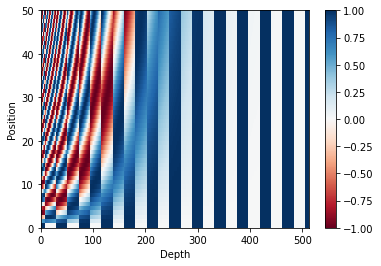

[[ 0.00000000e+00  1.00000000e+00  0.00000000e+00 ...  1.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [ 8.41471016e-01  5.40302277e-01  8.21856260e-01 ...  1.00000000e+00
   1.03663238e-04  1.00000000e+00]
 [ 9.09297466e-01 -4.16146815e-01  9.36414719e-01 ...  1.00000000e+00
   2.07326477e-04  1.00000000e+00]
 ...
 [ 1.23573124e-01 -9.92335498e-01  9.77189779e-01 ...  9.99987245e-01
   4.87215305e-03  9.99988139e-01]
 [-7.68254697e-01 -6.40144348e-01  7.31234014e-01 ...  9.99986708e-01
   4.97581484e-03  9.99987602e-01]
 [-9.53752637e-01  3.00592542e-01 -1.44028708e-01 ...  9.99986112e-01
   5.07947663e-03  9.99987125e-01]]


In [107]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

spe = sample_pos_encoding.pos_encoding.numpy()
print(spe[0])


In [108]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output



In [109]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs


In [110]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]


In [111]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)


인코더층 만들기

In [112]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


In [113]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


디코더층 만들기

In [114]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)


In [115]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)


In [116]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

Transformer 모델 생성.

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3197184     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

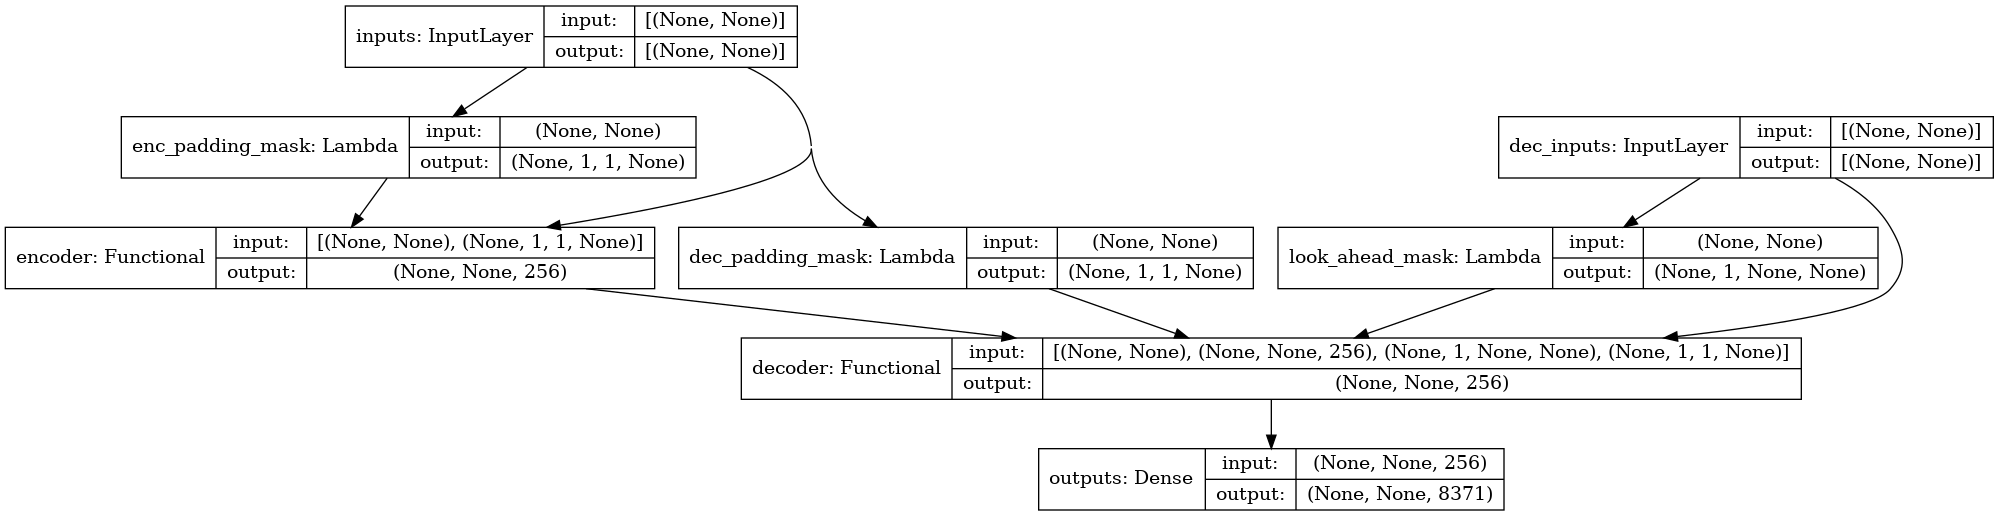

In [136]:
from tensorflow.keras.utils import plot_model 

tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 16 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.2 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

plot_model(model, show_shapes=True)

손실 함수

In [137]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)



커스텀 된 학습률

In [138]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


Text(0.5, 0, 'Train Step')

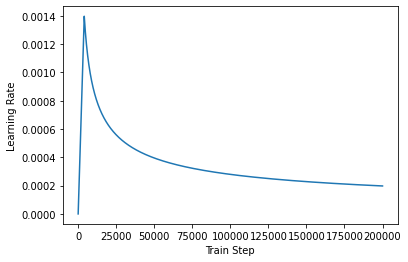

In [120]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [139]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])


In [140]:
EPOCHS = 50
history=model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
185/185 [==============================] - 19s 73ms/step - loss: 1.3184 - accuracy: 0.0315
Epoch 2/50
185/185 [==============================] - 14s 73ms/step - loss: 1.0127 - accuracy: 0.0600
Epoch 3/50
185/185 [==============================] - 14s 75ms/step - loss: 0.8152 - accuracy: 0.0609
Epoch 4/50
185/185 [==============================] - 14s 75ms/step - loss: 0.7541 - accuracy: 0.0630
Epoch 5/50
185/185 [==============================] - 14s 73ms/step - loss: 0.7159 - accuracy: 0.0654
Epoch 6/50
185/185 [==============================] - 14s 73ms/step - loss: 0.6790 - accuracy: 0.0677
Epoch 7/50
185/185 [==============================] - 14s 73ms/step - loss: 0.6391 - accuracy: 0.0704
Epoch 8/50
185/185 [==============================] - 14s 74ms/step - loss: 0.5942 - accuracy: 0.0740
Epoch 9/50
185/185 [==============================] - 14s 74ms/step - loss: 0.5456 - accuracy: 0.0788
Epoch 10/50
185/185 [==============================] - 14s 74ms/step - loss: 0.493

In [133]:
# epoch 50. head8, dropout 0.1
history_01 = history50

In [132]:
# epoch 50. head8, dropout 0.2
history_02 = history

In [141]:
# epoch 50. head16, dropout 0.2
history_12 = history

##### Step 5. 모델 평가하기

In [124]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)


In [125]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence


In [126]:
# 테스트용 문자열
test_sens = []
test_sens.append('무슨 일을 하고 싶어?')
test_sens.append('우리는 이뤄질 수 있을까?')
test_sens.append('어떨때 자신감 뿜뿜이니?')
test_sens.append('현재는 무슨 일을 해')
test_sens.append('하루 종일 핸드폰을 만지네')
test_sens.append('지금 일에 최선을 다하자')
test_sens.append('너 피부 너무 좋다')
test_sens.append('무슨 택배가 또오니?')
test_sens.append('친구들이랑 뭐 하고 싶어?')
test_sens.append('아구 너무 귀엽다')
test_sens.append('스트레스에는 뭐가 좋을까?')


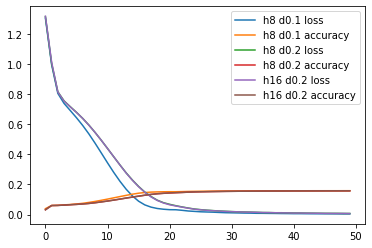

In [142]:
# 50 epoch 학습후..(mecab 미사용, drop 0.1/ drop 0.2)
plt.plot(history_01.history['loss'], label='h8 d0.1 loss')
plt.plot(history_01.history['accuracy'], label='h8 d0.1 accuracy')
plt.plot(history_02.history['loss'], label='h8 d0.2 loss')
plt.plot(history_02.history['accuracy'], label='h8 d0.2 accuracy')
plt.plot(history_12.history['loss'], label='h16 d0.2 loss')
plt.plot(history_12.history['accuracy'], label='h16 d0.2 accuracy')
plt.legend()
plt.show()


In [128]:
# 대화 테스트 (mecab 미사용, head8, drop 0.1)
for sentence in test_sens:
    sentence_generation(sentence)
    print("")

입력 : 무슨 일을 하고 싶어?
출력 :  일 분배를 다시 요청해보세요 . 

입력 : 우리는 이뤄질 수 있을까?
출력 :  그런 생각을 들게 하는 사람 상종하지 마세요 . 

입력 : 어떨때 자신감 뿜뿜이니?
출력 :  어깨 펴고 좀 더 당당해져도 돼요 . 

입력 : 현재는 무슨 일을 해
출력 :  곧 오겠네요 . 

입력 : 하루 종일 핸드폰을 만지네
출력 :  아무것도 하지마세요 . 

입력 : 지금 일에 최선을 다하자
출력 :  잘할 수 있을 거예요 . 

입력 : 너 피부 너무 좋다
출력 :  많은 걸 변화시키죠 . 

입력 : 무슨 택배가 또오니?
출력 :  고민이 많은가 봅니다 . 

입력 : 친구들이랑 뭐 하고 싶어?
출력 :  조금씩 더 행복해 질거 같아요 

입력 : 아구 너무 귀엽다
출력 :  친구가 보는 눈이 있네요 . 

입력 : 스트레스에는 뭐가 좋을까?
출력 :  잘 푸는 것도 중요해요 . 



In [135]:
# 대화 테스트 (mecab 미사용, head8, drop 0.2)
for sentence in test_sens:
    sentence_generation(sentence)
    print("")

입력 : 무슨 일을 하고 싶어?
출력 :  일 분배를 다시 요청해보세요 . 

입력 : 우리는 이뤄질 수 있을까?
출력 :  이제 그러면 돼요 . 

입력 : 어떨때 자신감 뿜뿜이니?
출력 :  당신이 그 꽃으로 만들어보세요 . 

입력 : 현재는 무슨 일을 해
출력 :  잊는 건 정말 힘든 일이에요 . 

입력 : 하루 종일 핸드폰을 만지네
출력 :  시간을 되돌릴 수 없어요 . 

입력 : 지금 일에 최선을 다하자
출력 :  지금 많이 위축된 상태인 것 같습니다 . 

입력 : 너 피부 너무 좋다
출력 :  힘든 시간 잘 버텨냈어요 . 

입력 : 무슨 택배가 또오니?
출력 :  오늘 헤어졌어 라고 하면 위로해 드려요 . 

입력 : 친구들이랑 뭐 하고 싶어?
출력 :  오늘은 그냥 뒹굴뒹글 같이 놀아요 . 

입력 : 아구 너무 귀엽다
출력 :  친구가 보는 눈이 있네요 . 

입력 : 스트레스에는 뭐가 좋을까?
출력 :  잘 푸는 것도 중요해요 . 



In [143]:
# 대화 테스트 (mecab 미사용, head16, drop 0.2)
for sentence in test_sens:
    sentence_generation(sentence)
    print("")

입력 : 무슨 일을 하고 싶어?
출력 :  잘할 수 있을 거니 걱정마세요 . 

입력 : 우리는 이뤄질 수 있을까?
출력 :  이제 기억을 놓아주세요 . 

입력 : 어떨때 자신감 뿜뿜이니?
출력 :  호감이 있을 수도 있어요 . 그렇지만 조금 더 상황을 지켜보세요 . 

입력 : 현재는 무슨 일을 해
출력 :  사람을 잊는다는 건 쉬운 일이 아니니까요 . 

입력 : 하루 종일 핸드폰을 만지네
출력 :  시간을 정해보세요 . 

입력 : 지금 일에 최선을 다하자
출력 :  지금 무슨 말을 해도 와닿지 않겠지만 잘 이겨낼 거라 믿어요 . 

입력 : 너 피부 너무 좋다
출력 :  돈을 모아서 다른 곳으로 이사갈 수 있을 거예요 . 

입력 : 무슨 택배가 또오니?
출력 :  오늘 택배기사님들 쉬는 날이예요 . 

입력 : 친구들이랑 뭐 하고 싶어?
출력 :  지금 무슨 말을 해도 와닿지 않겠지만 잘 이겨낼 거라 믿어요 . 

입력 : 아구 너무 귀엽다
출력 :  친구가 보는 눈이 있네요 . 

입력 : 스트레스에는 뭐가 좋을까?
출력 :  잘 푸는 것도 중요해요 . 



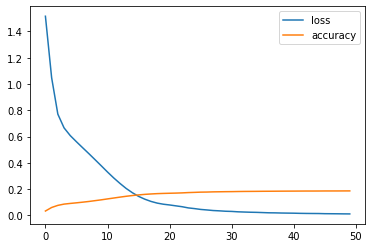

In [72]:
# 50 epoch 학습후..(mecab 사용)
plt.plot(history50.history['loss'], label='loss')
plt.plot(history50.history['accuracy'], label='accuracy')
plt.legend()
plt.show()


In [70]:
# 대화 테스트 (mecab 사용)
for sentence in test_sens:
    sentence_generation(sentence)
    print("")

입력 : 무슨 일을 하고 싶어?
출력 :  옷 사도 사도 모자라 요 . 

입력 : 우리는 이뤄질 수 있을까?
출력 :  자신 을 사랑 하 셨 네요 . 

입력 : 어떨때 자신감 뿜뿜이니?
출력 :  호감 을 표현 해 보 것 좋 을 것 같 아요 . 

입력 : 현재는 무슨 일을 해
출력 :  현재 즐기 면서 행복 하 게 사세요 . 

입력 : 하루 종일 핸드폰을 만지네
출력 :  어떻게 하 느냐 따라 달라질 거 예요 . 

입력 : 지금 일에 최선을 다하자
출력 :  최선 을 다 했 다면 그 시간 자체 즐기 면 돼요 . 

입력 : 너 피부 너무 좋다
출력 :  물 많이 드 시 고 얼른 주무세요 . 

입력 : 무슨 택배가 또오니?
출력 :  송장 번호 확인 해 보 세요 . 

입력 : 친구들이랑 뭐 하고 싶어?
출력 :  친구 을 잃 지 말 아요 . 

입력 : 아구 너무 귀엽다
출력 :  친구 보 눈 있 네요 . 

입력 : 스트레스에는 뭐가 좋을까?
출력 :  회사 자신 대해서 더 공부 해서 자신감 을 가져 보 세요 . 



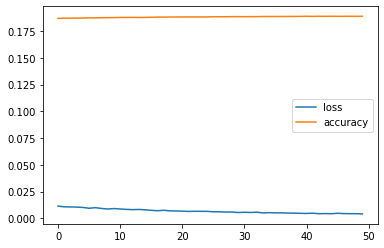

In [74]:
# 100 epoch 학습후.. (mecab사용)
plt.plot(history100.history['loss'], label='loss')
plt.plot(history100.history['accuracy'], label='accuracy')
plt.legend()
plt.show()


In [75]:
# 대화 테스트 (mecab 사용)
for sentence in test_sens:
    sentence_generation(sentence)
    print("")

입력 : 무슨 일을 하고 싶어?
출력 :  추억 남 았 다면 보 고 싶 고 궁금 할 거 예요 . 

입력 : 우리는 이뤄질 수 있을까?
출력 :  사랑 앞 미련 없 사람 없 을 거 예요 . 

입력 : 어떨때 자신감 뿜뿜이니?
출력 :  여자 친구 생각 하 지 마세요 . 

입력 : 현재는 무슨 일을 해
출력 :  현재 즐기 면서 행복 하 게 사세요 . 

입력 : 하루 종일 핸드폰을 만지네
출력 :  저 둘 걸 좋 아 해요 . 

입력 : 지금 일에 최선을 다하자
출력 :  같이 살 자고 프로 포즈 해 보 세요 . 

입력 : 너 피부 너무 좋다
출력 :  물 많이 드 시 고 얼른 주무세요 . 

입력 : 무슨 택배가 또오니?
출력 :  무 의식 진심 을 말 하 죠 . 

입력 : 친구들이랑 뭐 하고 싶어?
출력 :  그런 사람 만나 면 저 소개 시켜 주 세요 . 

입력 : 아구 너무 귀엽다
출력 :  듣 기 만 해도 괜찮 아요 . 

입력 : 스트레스에는 뭐가 좋을까?
출력 :  사랑 을 쟁취 하 거 예요 . 



##### Step 6. 회고

- mecab 형태소 분석을 하고, 불용어를 사용하는 경우 불용어 제거로 인하여 생성 문장이 자연스럽지 않았다.  
- loss는 50에서 거의 수렴상태였는데, 100회 시행시 과적합으로 더 부자연스러운 대답이 생성되었다.  

- custom learning rate를 통하여 loss는 급격히 떨어지는 것을 확인할 수 있었다.  
- dropout을 0.1,0.2로 변경해보면 loss가 좀더 천천히 수렴하는 것을 확인할 수 있다.  
- head_num을 8,16으로 변경해보면 16일 경우가 대답이 더 부자연스러웠다.  
- 아직 transformer의 구조에 대한 이해와 개선은 시간이 더 필요해 보임.  
- mecab을 통해서 불용어를 제거한다음, 디코딩시 다시 넣어 줄 수 있다면 50회 학습한 모델의 대답이 가장 자연스러울 것 같다.    